In [1]:
import pandas as pd

## Explore COCO HRNet person detections

COCO bounding box annotations are not normalized and in the form:

```json
[x_min, y_min, width, height]
```

In [2]:
val_path = "data/coco2017/COCO_val2017_detections_AP_H_56_person.json"
val_boxes = pd.read_json(val_path)
display(val_boxes.head(5))
sample_bbox = val_boxes.head().iloc[0]["bbox"]
print(f"Sample bbox: {sample_bbox}")

bbox  category_id  image_id  \
0  [249.8199079291458, 175.21093805640606, 74.004...            1    532481   
1  [284.07836701140275, 370.43747059580454, 13.84...            1    532481   
2  [244.05099093550018, 170.61324112294565, 74.56...            1    532481   
3  [285.7852415208732, 370.21400193144893, 10.915...            1    532481   
4  [254.66838783379924, 177.22587387050734, 65.52...            1    532481   

      score  
0  0.999274  
1  0.983319  
2  0.471152  
3  0.427866  
4  0.212189

Sample bbox: [249.8199079291458, 175.21093805640606, 74.00419360691592, 55.626325589288854]


## Transform YOLO Detections to same COCO HRNet format

YOLO assigns an independent .txt file for each image, where each line contains a different detection. The format is the following:

```txt
class_id, x_centre, y_centre, width, height, score
```

Following the class id assignation of COCO, the class 0 belongs to 'person', which are the detections we are interested in. Bounding box coordinates are further normalized with respec to to the image size

In [3]:
from src.utils import load_img_info

test_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_test.json", "test", rm_extension=True)
val_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_val.json", "val", rm_extension = True)
merged_anns = pd.concat([val_anns,test_anns])
merged_anns.sample(5)

file_name  height  width  image_id split
36   thermal_11_23_40     480    640        36  test
18     thermal_10_9_1     480    640        18  test
70         FLIR_06170     146    157        70   val
193        FLIR_01825     259    395       193   val
101   thermal_11_9_29     480    640       101  test

Load Yolov7 detections into a dataframe. This data will be then crossed with previous annotations

In [11]:
import glob
import os

PRETRAIN = "gray"

def load_yolo_det(det_dir, split):
    det_files = glob.glob(os.path.join(det_dir,"*.txt"))
    data = []
    for file in det_files:
        filename = file.split("/")[-1].split(".")[0]
        det_df = pd.read_csv(file, sep=" ", header=None, names=["class_id","x_centre","y_centre","width","height"])
        det_df["file_name"] = filename
        data.append(det_df)
    data = pd.concat(data)
    data["split"] = split
    # we filter to person detections only
    relevant_data = data[data["class_id"] == 0]
    return relevant_data

val_det =  load_yolo_det(f"data/thermal_pose/yolo_fmt/detections/finetuned_{PRETRAIN}/val/labels","val")
test_det = load_yolo_det(f"data/thermal_pose/yolo_fmt/detections/finetuned_{PRETRAIN}/test/labels","test")
merged_det = pd.concat([val_det, test_det])
merged_det.sample(5)

class_id  x_centre  y_centre     width    height         file_name split
2         0  0.814062  0.367188  0.362500  0.734375          IMG_0413   val
3         0  0.583984  0.525000  0.353906  0.751042          IMG_2694   val
0         0  0.691016  0.518359  0.202344  0.534115  thermal_10_55_55  test
3         0  0.549180  0.518450  0.197001  0.314576        FLIR_01868   val
6         0  0.226416  0.650651  0.360449  0.621615  thermal_10_56_32  test

We now cross information to associate image id to each detection 

In [12]:
crossed_data = pd.merge(merged_anns, merged_det,how='inner',on = ["file_name","split"], suffixes=('_ann','_det'))
crossed_data.sample(5)

file_name  height_ann  width_ann  image_id split  class_id  \
1324        FLIR_08491         179        210       173   val         0   
652              00101         480        640        78   val         0   
649              00101         480        640        78   val         0   
737         FLIR_03130         354        499        91   val         0   
1892  thermal_11_37_30         480        640        39  test         0   

      x_centre  y_centre  width_det  height_det  
1324  0.418761  0.264450   0.422280    0.502294  
652   0.603906  0.550651   0.370313    0.686198  
649   0.653906  0.551172   0.225000    0.614323  
737   0.497687  0.073376   0.042190    0.118117  
1892  0.743359  0.500000   0.513281    1.000000

In [13]:
def yolo_to_coco(data_row):
    bbox_width = round(data_row["width_det"]*data_row["width_ann"],6)
    bbox_height = round(data_row["height_det"]*data_row["height_ann"],6)
    bbox_x1 = round(data_row["x_centre"]*data_row["width_ann"] - bbox_width/2,6)
    bbox_y1 = round(data_row["y_centre"]*data_row["height_ann"] - bbox_height/2,6)
    return [bbox_x1, bbox_y1, bbox_width, bbox_height]

clean_det_data = crossed_data.copy()
clean_det_data["bbox"] = clean_det_data.apply(lambda data_row: yolo_to_coco(data_row), axis=1)
# map from 0 to 1 class id
clean_det_data["class_id"] = 1
clean_det_data = clean_det_data.rename(columns = {"class_id":"category_id"})
relevant_cols = ["bbox","category_id","image_id", "file_name", "split"]
clean_det_data = clean_det_data[relevant_cols]
clean_det_data.head()

bbox  category_id  image_id  \
0  [116.900096, 58.099968, 130.699776, 393.099776]            1         0   
1      [378.4, 101.800192, 122.400256, 367.799808]            1         0   
2     [90.500096, 55.699712, 63.399936, 227.10016]            1         0   
3      [85.74976, 52.09984, 112.65024, 245.100032]            1         0   
4    [90.400256, 57.099776, 62.199808, 142.900224]            1         0   

     file_name split  
0  frame_04126   val  
1  frame_04126   val  
2  frame_04126   val  
3  frame_04126   val  
4  frame_04126   val

Finally, save annotations to disk

In [ ]:
import os
import json

def save_clean_data(clean_data: pd.DataFrame, split):
    output_dir = f"data/thermal_pose/coco_fmt/detections/{PRETRAIN}_pretrain"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    subset_data = clean_data[clean_data["split"] == split].drop(columns="split")
    output_file = os.path.join(output_dir, f"thermalPose_yolov7_person_detections_{split}.json")
    records = subset_data.to_dict('records')
    with open(output_file,'w') as out:
        json.dump(records, out, indent=4)

save_clean_data(clean_det_data, "val")
save_clean_data(clean_det_data, "test")

## Filter COCO detections to person detections

In [12]:
from src.utils import load_img_info
import pandas as pd

test_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_test.json", "test", rm_extension=True)
val_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_val.json", "val", rm_extension = True)
merged_anns = pd.concat([val_anns,test_anns])
merged_anns.sample(5)

file_name  height  width  image_id split
76   thermal_10_55_26     480    640        76  test
116            runner     187    270       116   val
24    thermal_11_31_1     480    640        24  test
140        FLIR_02306     346    375       140   val
39   thermal_11_37_30     480    640        39  test

In [13]:
import json
import pandas as pd

SPLIT = "val"
PRETRAIN = "color"

input_path = f"data/thermal_pose/yolo_fmt/detections/{PRETRAIN}/{SPLIT}/best_predictions.json"
output_path = f"data/thermal_pose/coco_fmt/detections/{PRETRAIN}/thermalPose_yolov7_person_detections_{SPLIT}.json"

with open(input_path) as file:
    data = json.load(file)
    new_data = []
    for detection in data:
        if detection["category_id"] == 0:
            detection["file_name"] = detection["image_id"]
            detection.pop("image_id")
            detection["split"] = SPLIT
            detection["category_id"] = 1
            new_data.append(detection)

new_data = pd.DataFrame(new_data)
new_data.head()

category_id                              bbox    score  file_name split
0            1  [24.832, 36.486, 21.023, 55.301]  0.86719  Image_438   val
1            1  [107.174, 19.69, 19.043, 50.883]  0.77734  Image_438   val
2            1  [81.047, 18.434, 18.586, 50.883]  0.60840  Image_438   val
3            1   [94.91, 22.185, 16.605, 52.387]  0.19128  Image_438   val
4            1   [27.955, 15.044, 7.198, 15.768]  0.07776  Image_438   val

In [14]:
crossed_data = pd.merge(merged_anns, new_data,how='inner',on = ["file_name","split"], suffixes=('_ann','_det'))
crossed_data.sample(5)

file_name  height  width  image_id split  category_id  \
3195  FLIR_06559     211    242       154   val            1   
707   FLIR_00320     512    640        37   val            1   
4022  FLIR_03104     512    640       178   val            1   
3841  FLIR_03654     381    389       174   val            1   
2941  FLIR_06326     242    336       136   val            1   

                                   bbox    score  
3195  [37.554, 100.206, 11.982, 41.406]  0.00525  
707     [153.25, 191.875, 27.5, 52.625]  0.24048  
4022     [342.75, 132.125, 20.5, 71.25]  0.00432  
3841  [70.753, 154.135, 26.323, 26.171]  0.00269  
2941    [0.304, 154.538, 4.981, 10.522]  0.00149

In [15]:
clean_det_data = crossed_data.copy()[["bbox","category_id","image_id","score","split","file_name"]]

In [16]:
def save_clean_data(clean_data: pd.DataFrame, split):
    output_dir = f"data/thermal_pose/coco_fmt/detections/{PRETRAIN}"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    subset_data = clean_data[clean_data["split"] == split].drop(columns="split")
    output_file = os.path.join(output_dir, f"thermalPose_yolov7_person_detections_{split}.json")
    records = subset_data.to_dict('records')
    with open(output_file,'w') as out:
        json.dump(records, out, indent=4)

save_clean_data(clean_det_data, SPLIT)

## Visualize Person Detections

---

### Transformed COCO Detections

In [18]:
import pandas as pd

ann_path = "data/thermal_pose/coco_fmt/detections/color/thermalPose_yolov7_person_detections_val.json"
split = ann_path.split("_")[-1].split(".")[0]

data = pd.read_json(ann_path)
data.head()

bbox  category_id  image_id    score    file_name
0  [377.8, 99.7, 123.4, 370.3]            1         0  0.95801  frame_04126
1  [117.0, 58.5, 130.4, 390.7]            1         0  0.94824  frame_04126
2    [90.9, 56.3, 63.8, 167.7]            1         0  0.81885  frame_04126
3  [82.05, 62.2, 77.75, 215.8]            1         0  0.03699  frame_04126
4  [317.2, 89.4, 184.0, 401.0]            1         0  0.01942  frame_04126

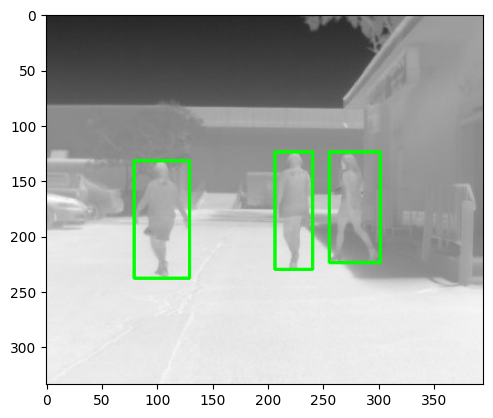

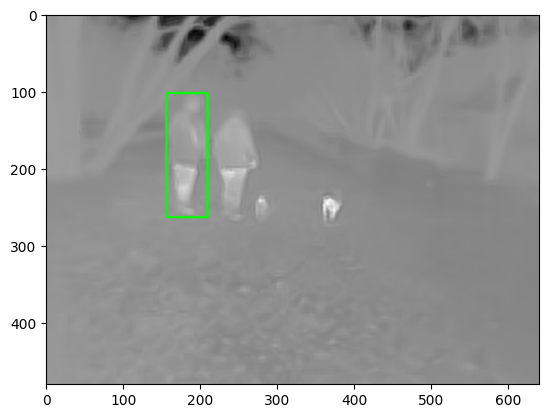

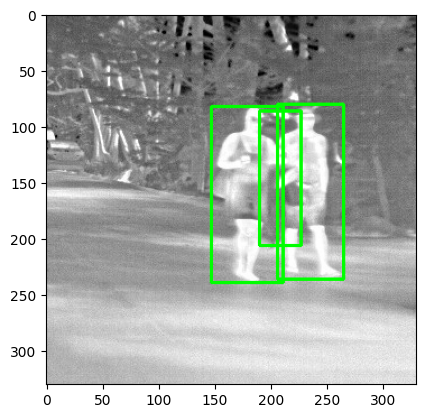

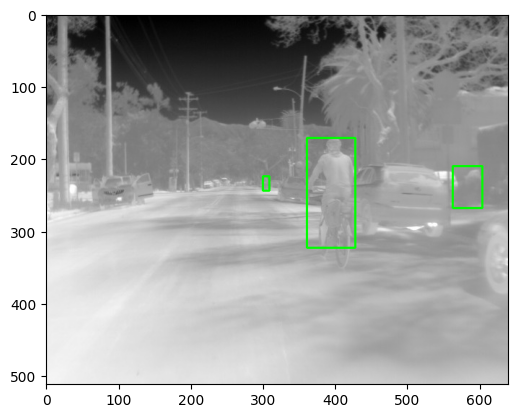

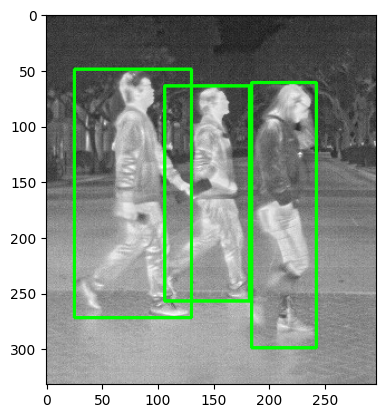

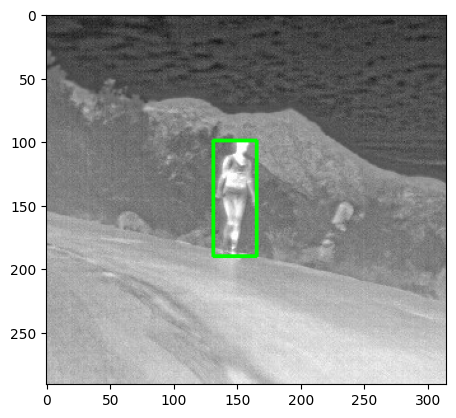

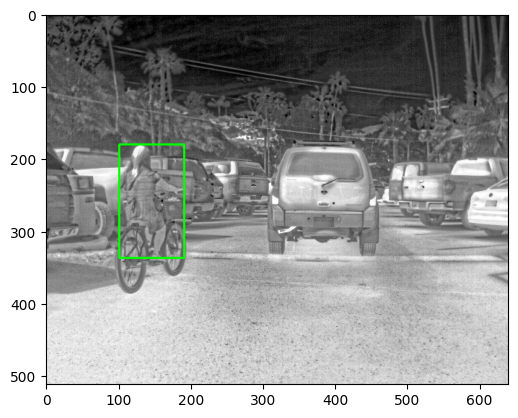

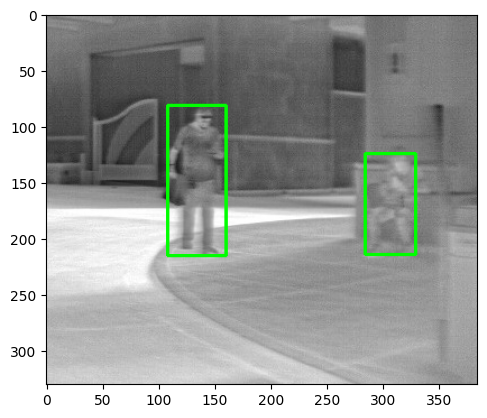

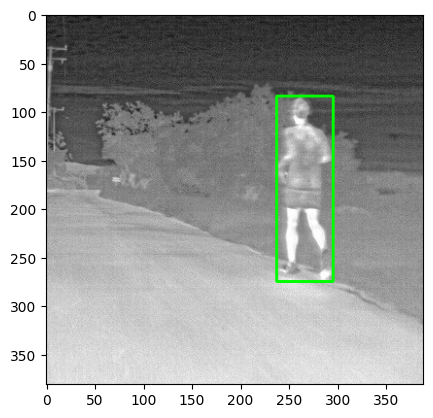

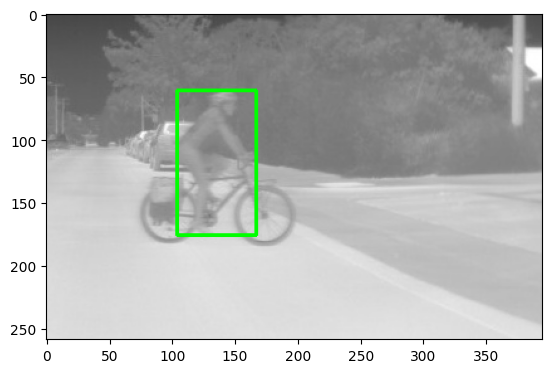

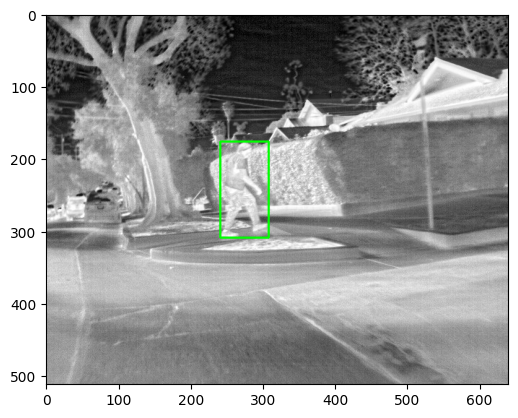

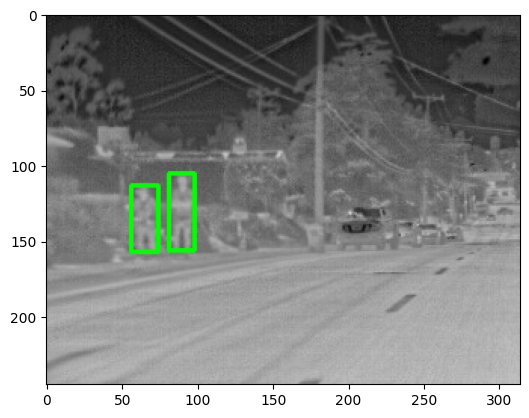

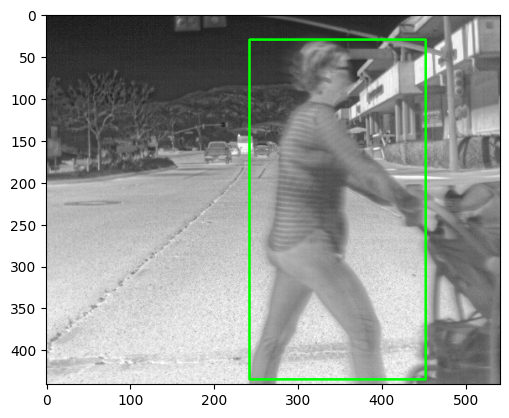

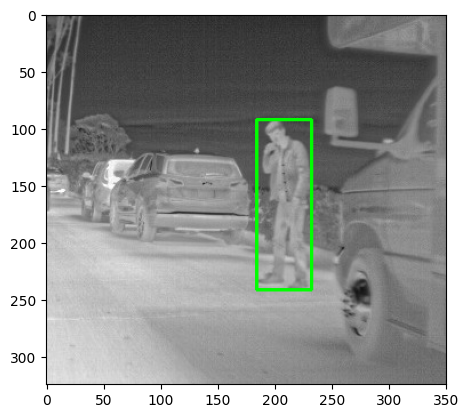

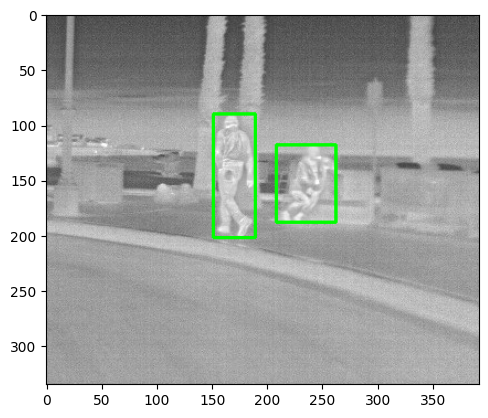

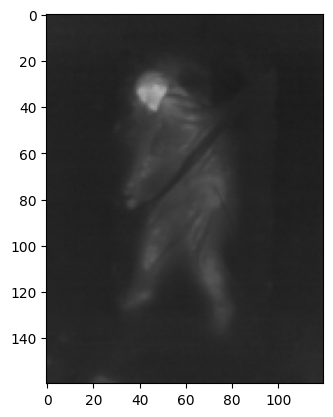

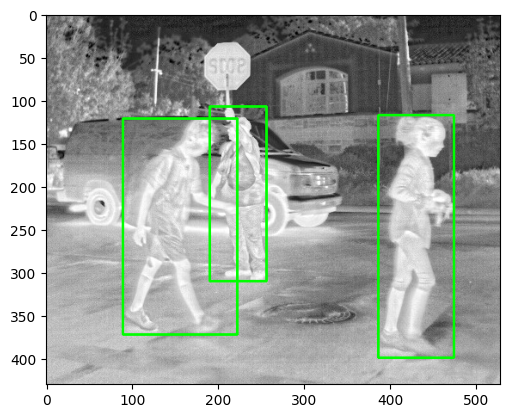

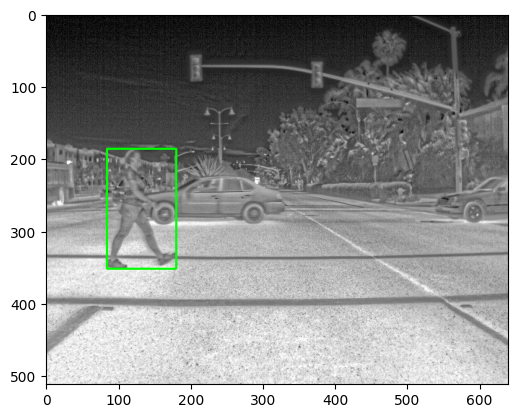

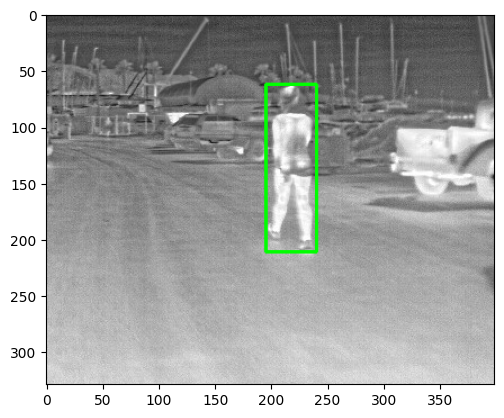

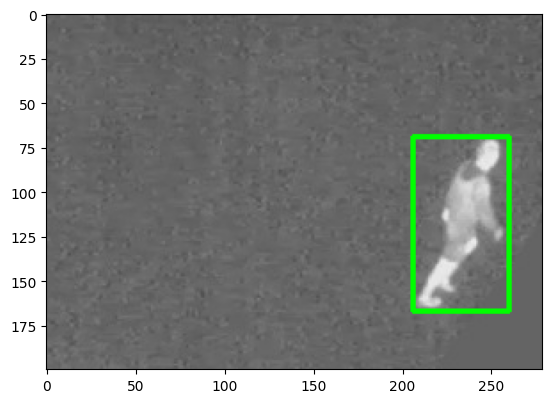

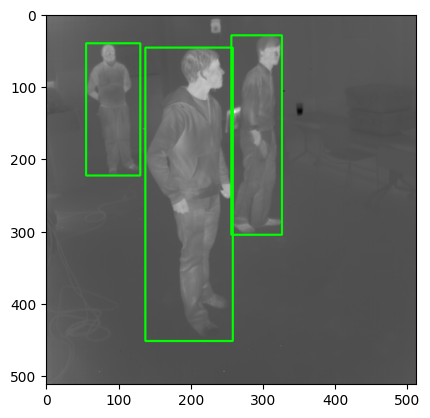

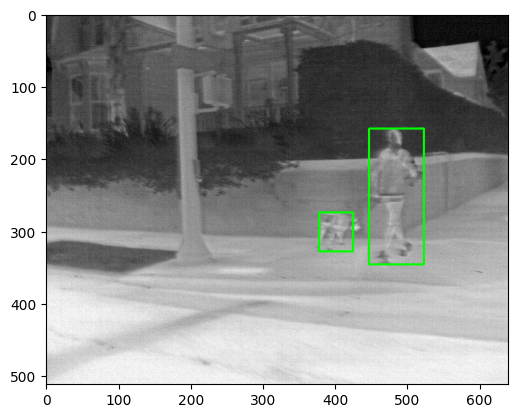

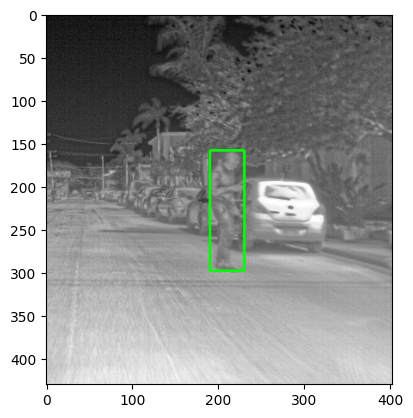

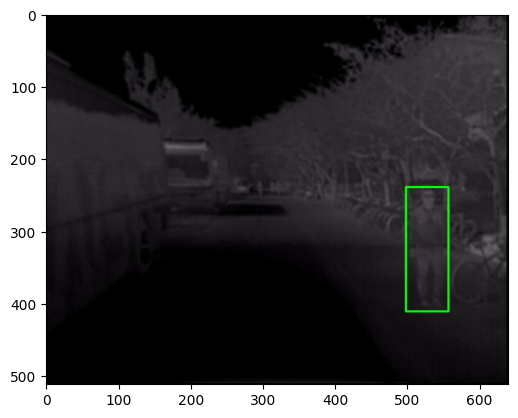

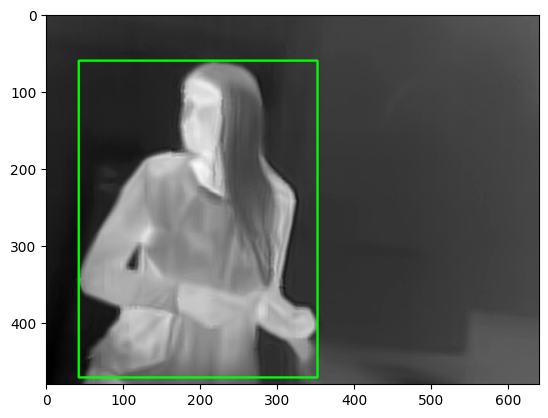

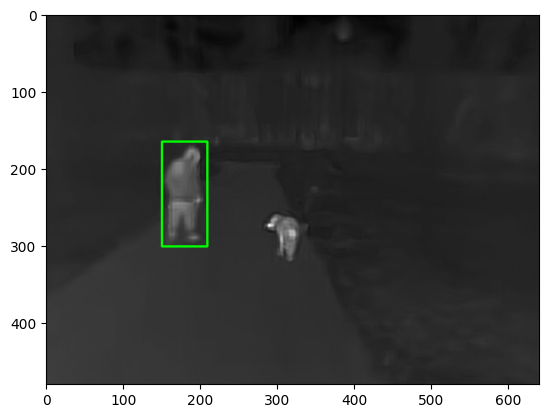

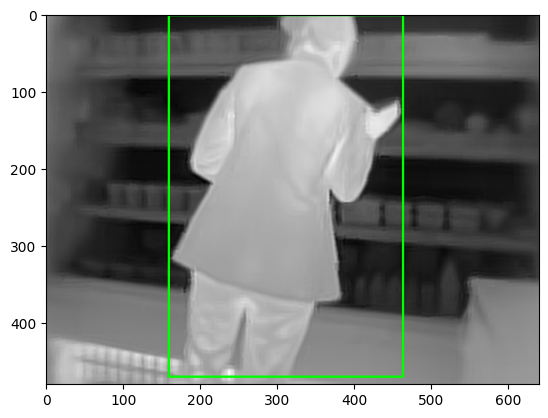

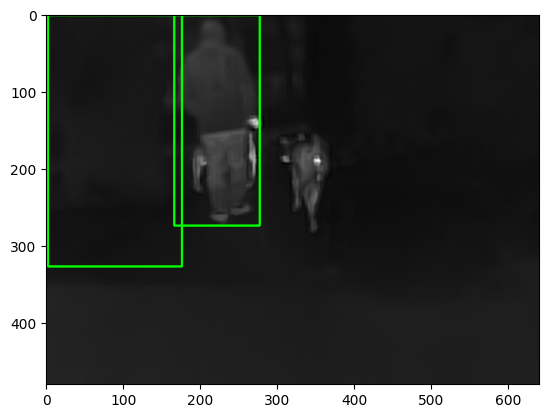

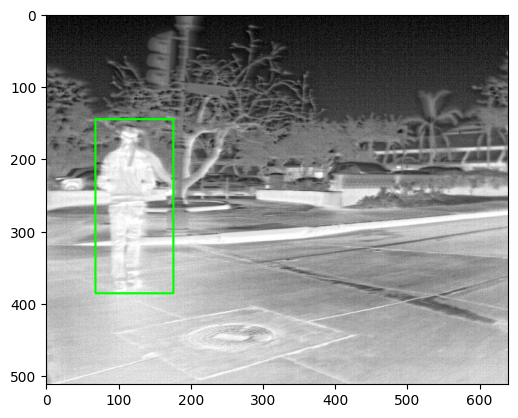

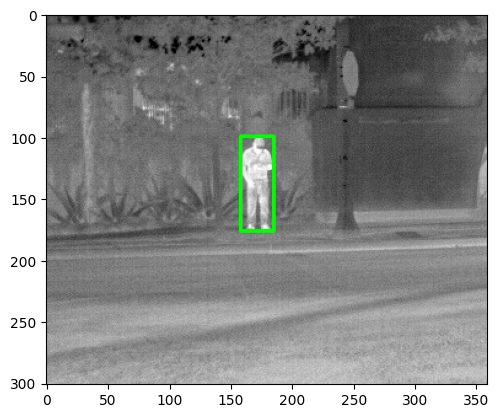

In [50]:
import cv2
import os
import matplotlib.pyplot as plt
import glob

thr_cutoff = 0.25
n_max_show = 30

grouped_data = data.copy().sample(frac=1).groupby("file_name", sort= False)
files = glob.glob(f"data/thermal_pose/coco_fmt/dataset/{split}/*")
map_to_src = {file.split("/")[-1].split(".")[0]:file for file in files}
counter = 0
for filename, img_data in grouped_data:
    img_data = img_data[img_data["score"] >= thr_cutoff]
    img_src = map_to_src[filename]
    img = cv2.imread(img_src)
    for ann in img_data["bbox"]: 
        x1 = int(ann[0])
        y1 = int(ann[1])
        x2 = int(x1 + ann[2])
        y2 = int(y1 + ann[3])
        img = cv2.rectangle(img, (x1,y1),(x2,y2), color = (0,255,0),thickness = 2)
    plt.imshow(img)
    plt.show()
    counter += 1
    if counter == n_max_show:
        break

    